## 📰 Fake and Real News Detection
In this project, we aim to classify news articles as either **fake** or **real** using deep learning techniques.  
We will preprocess the data, build a neural network, and evaluate the performance.

- Dataset: [Fake and Real News Dataset](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset)
- Contains two /data/raw/: `Fake.csv` and `True.csv`
- Columns: `title`, `text`, `subject`, `date`


In [2]:
import zipfile

with zipfile.ZipFile("../data/raw/archive.zip", "r") as zip_ref:
    zip_ref.extractall("../data/raw/")

In [ ]:
import pandas as pd


fake = pd.read_csv("../data/raw/Fake.csv")
true = pd.read_csv("../data/raw/True.csv")

fake['label'] = 0
true['label'] = 1

df = pd.concat([fake[['title', 'text', 'label']], true[['title', 'text', 'label']]], ignore_index=True)
df['news'] = df['title'] + " " + df['text']
df.drop(columns=['title', 'text'], inplace=True)
df.head(15)

,label,news
0,0,Donald Trump Sends Out Embarrassing New Year’...
1,0,Drunk Bragging Trump Staffer Started Russian ...
2,0,Sheriff David Clarke Becomes An Internet Joke...
3,0,Trump Is So Obsessed He Even Has Obama’s Name...
4,0,Pope Francis Just Called Out Donald Trump Dur...
5,0,Racist Alabama Cops Brutalize Black Boy While...
6,0,"Fresh Off The Golf Course, Trump Lashes Out A..."
7,0,Trump Said Some INSANELY Racist Stuff Inside ...
8,0,Former CIA Director Slams Trump Over UN Bully...
9,0,WATCH: Brand-New Pro-Trump Ad Features So Muc...


 - Removing duplicate news articles

In [2]:
df['label'].value_counts()

label
0    23481
1    21417
Name: count, dtype: int64

In [3]:
print(df['news'].duplicated().sum(), ' Removed!')
df.drop_duplicates(inplace=True)

5793  Removed!


In [4]:
df.isna().sum()

label    0
news     0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39105 entries, 0 to 44897
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   39105 non-null  int64 
 1   news    39105 non-null  object
dtypes: int64(1), object(1)
memory usage: 916.5+ KB


- Preprocessing is performed using the `cleantext` module, combined with NLTK's stopwords and WordNetLemmatizer for effective text cleaning and normalization.

In [6]:
from tqdm.notebook import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from nltk.tokenize import word_tokenize
from cleantext import clean

tqdm.pandas()

nltk.data.path.append("~/nltk_data/corpora/stopwords")
nltk.data.path.append("~/nltk_data/corpora/wordnet")
nltk.data.path.append("~/nltk_data/corpora/omw-1.4")

lemmatizer = WordNetLemmatizer()
stopwords = set(stopwords.words('english'))

def clean_text_with_nltk(text):
    no_html = re.sub(r'<.*?>', '', text)
    text = clean(
        no_html,
        no_digits=True,
        no_numbers=True,
        no_emails=True,
        no_urls=True,
        no_punct=True,
        lower=True,
        strip_lines=True,
        lang='en'
    )
    
    words = word_tokenize(text)
    removed_stopwords = [word for word in words if not word in stopwords]
    lemmatized = [lemmatizer.lemmatize(word) for word in removed_stopwords]

    return ' '.join(lemmatized)


df['cleaned_by_nltk'] = df['news'].progress_apply(clean_text_with_nltk)

del tqdm

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


  0%|          | 0/39105 [00:00<?, ?it/s]

In [7]:
print(df['news'].loc[1])
print(df['cleaned_by_nltk'].loc[1])

 Drunk Bragging Trump Staffer Started Russian Collusion Investigation House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former Trump campaign adviser George Papadopoulos was drunk in a wine bar when he revealed knowledge of Russian opposition research on Hillary Clinton.On top of that, Papadopoulos wasn t just a covfefe boy for Trump, as his administration has alleged. He had a much larger role, but none so damning as being a drunken fool in a wine bar. Coffee boys  don t help to arrange a New York meeting between Trump and President Abdel Fattah el-Sisi of Egypt two months before the election. It was known before that the 

###  Text Length Analysis and Outlier Removal

To ensure consistency in input size and improve model training, we analyzed the length of each cleaned news article (in terms of word count).  
Using a boxplot, we visualized the distribution and identified unusually long texts (e.g., above 1000 words).  
These extreme cases were removed to reduce noise and stabilize training.


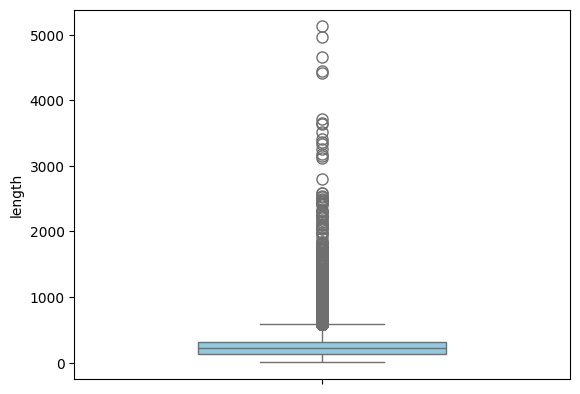

In [8]:
import seaborn as sns

df['length'] = df['cleaned_by_nltk'].apply(str.split).apply(len)

sns.boxplot(df['length'], color="skyblue", fliersize=8, width=0.5)
sns.set_context("talk", font_scale=0.5)

<Axes: ylabel='length'>

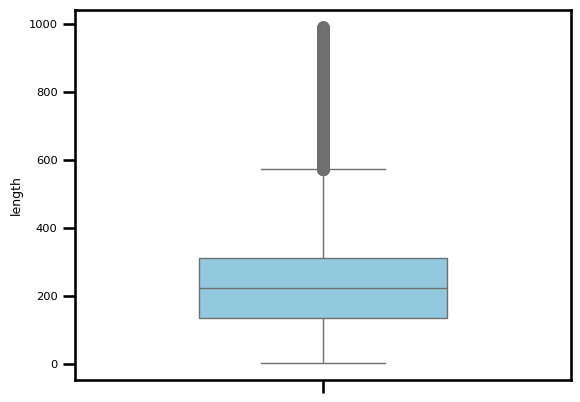

In [9]:
df[df['length'] > 1000]['length'].count()

df = df[df['length'] < 1000]
sns.boxplot(df['length'], color="skyblue", fliersize=8, width=0.5)

###  Text Vectorization and Train-Test Split

In this step, we convert the cleaned text into numerical format suitable for neural network input:

- **Tokenizer**: Converts each word to a unique integer ID based on word frequency.
- **Text to Sequences**: Transforms the text into sequences of integers.
- **Padding**: Ensures all sequences have the same length (200 words) using post-padding.
- **Train-Test Split**: Splits the dataset into 80% for training and 20% for testing.

These transformations prepare the data for feeding into an embedding layer and model training.


In [11]:
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


X = df['cleaned_by_nltk']
y = df['label']

tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
word_idx = len(tokenizer.word_index) + 1
maxlen = 200
padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')

x_train, x_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2)


2025-07-17 10:32:48.184552: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752735768.196577  106452 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752735768.199992  106452 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752735768.208949  106452 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752735768.208958  106452 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752735768.208960  106452 computation_placer.cc:177] computation placer alr

###  Model Architecture: Bidirectional LSTM for Fake News Detection

In this section, we define a deep learning model using Keras Functional API.  
The architecture includes:

- **Embedding Layer**: Converts input tokens to dense vectors of fixed size.  
- **Bidirectional LSTM**: Captures both past and future context in the sequence.  
- **Dropout Layers**: Prevents overfitting by randomly dropping units.  
- **Dense Layers**: For high-level feature extraction and final classification.  

The final layer uses a sigmoid activation to output the probability of the news being **real (1)** or **fake (0)**.  
The model is compiled with `binary_crossentropy` loss and optimized using the Adam optimizer.


In [12]:
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Input
from keras.models import Model
from keras.optimizers import Adam

input_layer = Input(shape=(maxlen,))
x = Embedding(input_dim=word_idx, output_dim=128, input_length=maxlen)(input_layer)
x = Bidirectional(LSTM(64, return_sequences=False))(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=outputs)
print(model.summary())

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=64)

/home/mohammad/Documents/SentimentAnalysis/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1752735778.081872  106452 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8920 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 200, 128)       │    25,623,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,738,625 (98.19 MB)

 Trainable params: 25,738,625 (98.19 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5


I0000 00:00:1752735781.385752  114361 cuda_dnn.cc:529] Loaded cuDNN version 90501


487/487 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.7277 - loss: 0.4834 - val_accuracy: 0.9979 - val_loss: 0.0069
Epoch 2/5
487/487 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9985 - loss: 0.0095 - val_accuracy: 0.9982 - val_loss: 0.0050
Epoch 3/5
487/487 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9996 - loss: 0.0032 - val_accuracy: 0.9987 - val_loss: 0.0045
Epoch 4/5
487/487 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9994 - loss: 0.0024 - val_accuracy: 0.9987 - val_loss: 0.0052
Epoch 5/5
487/487 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9996 - loss: 0.0025 - val_accuracy: 0.9985 - val_loss: 0.0058


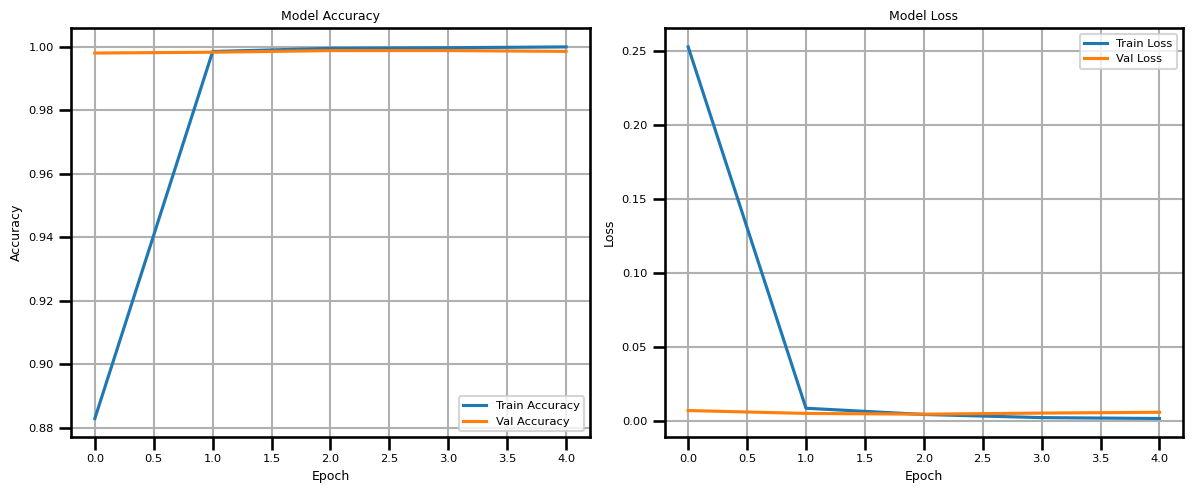

In [13]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [14]:
model.evaluate(x_test, y_test)

244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9988 - loss: 0.0047


[0.005782804451882839, 0.9984577894210815]

In [15]:
model.save('../models/model.keras')
df['cleaned_by_nltk'].to_csv('../data/processed/processed.csv', index=False)

2025-07-17 10:39:10.659113: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102492672 exceeds 10% of free system memory.
2025-07-17 10:39:10.897538: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102492672 exceeds 10% of free system memory.
2025-07-17 10:39:11.071868: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102492672 exceeds 10% of free system memory.


*Jafa DsX*